# Finite Difference Model

Use Finite Difference method to value an option.

The underlying code used is based on the fd_runner method [here](https://github.com/domokane/CompFin/blob/main/Week%204/xladdin/Utility/kBlack.cpp)

In [1]:
from copy import copy

import numpy as np
import matplotlib.pyplot as plt

from financepy.models.finite_difference import (
    dx, dxx, fd_roll_backwards, fd_roll_forwards, black_scholes_fd)
from financepy.utils.math import band_matrix_multiplication, solve_tridiagonal_matrix
from financepy.utils.date import Date
from financepy.utils.global_types import OptionTypes
from financepy.products.equity.equity_vanilla_option import EquityVanillaOption
from financepy.market.curves.discount_curve_flat import DiscountCurveFlat

In [43]:
expiry_dt = Date(1, 7, 2015)
strike_price = 100.0
opt_type = OptionTypes.EUROPEAN_CALL

call_option = EquityVanillaOption(expiry_dt, strike_price, opt_type)

value_dt = Date(1, 1, 2015)

time_to_expiry = (expiry_dt - value_dt)/365.25

stock_price = 100
volatility = 0.30
interest_rate = 0.05
dividend_yield = 0.01

num_std = 5
num_samples = 200
num_time_steps = 50

In [44]:
res = black_scholes_fd(spot_price=stock_price, volatility=volatility,
                        time_to_expiry=time_to_expiry,
                        strike_price=100.0, risk_free_rate=interest_rate,
                        dividend_yield=dividend_yield, opt_type=opt_type, num_time_steps=num_time_steps, num_samples=num_samples, num_std=num_std)

In [45]:
print(res)


9.295943880708233


In [39]:
# Create samples (this is done in black_scholes_fd
# but we do it here for plotting)
time_to_expiry = (expiry_dt - value_dt) / 365
std = volatility * (time_to_expiry ** 0.5)
xl = -num_std * std
xu = num_std * std
d_x = (xu - xl) / max(1, num_samples)
num_samples = 1 if num_samples <= 0 or xl == xu else num_samples + 1
s = np.zeros(num_samples)
s[0] = stock_price * np.exp(xl)
ds = np.exp(d_x)
for i in range(1, num_samples):
    s[i] = s[i - 1] * ds

ValueError: x and y must have same first dimension, but have shapes (205,) and (1,)

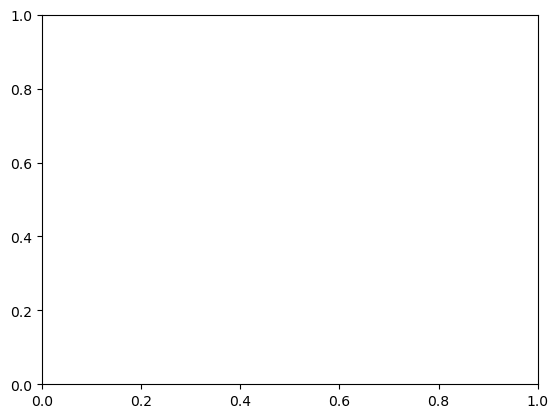

In [40]:
plt.plot(s, res)
plt.plot(s[len(s)//2], v, "*")
plt.hlines(v, 0, s[-1],"g", "dashed")
plt.xlabel("X")
plt.ylabel("Price")
plt.xlim((s[0], s[-1]))
plt.grid()

In [ ]:
print(f"Option value is ${v:.2f}")

Option value is $9.30
